Пакеты

* [Неоднородные БПФ](https://github.com/JuliaApproximation/FastTransforms.jl)  
* [FFTW](https://github.com/JuliaMath/FFTW.jl)

Фурье:
* [БПФ](http://bourabai.ru/graphics/fft7.htm)
* [Habr 1](https://habr.com/ru/post/196374/)
* [Habr 2](https://habr.com/ru/post/269991/)

In [1]:
using Plots, FFTW

┌ Info: Recompiling stale cache file C:\Users\User\.julia\compiled\v1.2\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


# Fast Fourier Transform

$$
\operatorname{DFT}(A)[k] =
  \sum_{n=1}^{\operatorname{length}(A)}
  \exp\left(-i\frac{2\pi
  (n-1)(k-1)}{\operatorname{length}(A)} \right) A[n].
$$

Выполним **быстрое Фурье преобразование** для функции Гаусса:

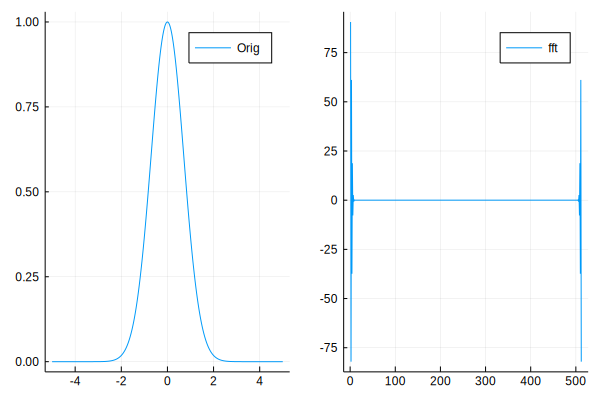

In [2]:
t = collect( range(-5,5,length = 512) )
f(x) = exp(-x^2)
f1 = f.(t)

plot([t, [1:512;] ], [f1, real( fft(f1) )  ], layout = 2, lab = ["Orig" "fft"] )

В таком виде трулно выудить полезную информацию. Нужна выполнить [ряд преобразований](http://www.phys.nsu.ru/cherk/Vestnik_Fourier_my_15_09.pdf)

In [3]:
function fftn(x::T, y::T, a::Int64, b::Int64) where T>:Array{Float64, 1}
    N = length(y)
    Tm = abs(x[end] - x[1]) # длительность сигнала
    dt = Tm/(N-1)
    half = N ÷ 2+1
    
    F = fft(y) # быстрое фурье
    F1 = F[1:half] # Выделение первых N/2+1 (положительные частоты)
    F2 = F[half:N] # Выделение спектра отрицательных частот
    F = abs.( [F2; F1] ) / N * sqrt(2pi) # Объединение спектра и нормировка
    # высота = амплитуда постоянной составляющей
    # Вычисление вектора частот:
    dnu = (N-1)/(N*Tm) # Шаг частоты
    nuNyq = 1/(2*dt) # Частота Найквиста
    nu = -nuNyq .+ dnu*[0:N;]

    mnu = round( abs( nu[argmax(F)] ), digits = 3)
    println("nu: $mnu Hz") # выводим одну из частот
    
    p1 = plot(x, y, lab = "Orig", xaxis = "t, s")
    p2 = plot(nu[a:b], F[a:b], marker = :circle, lab = "fft norm-d", xaxis = "freq, Hz")
    plot(p1, p2, layout = (2,1))
end

fftn (generic function with 1 method)

nu: 0.0 Hz


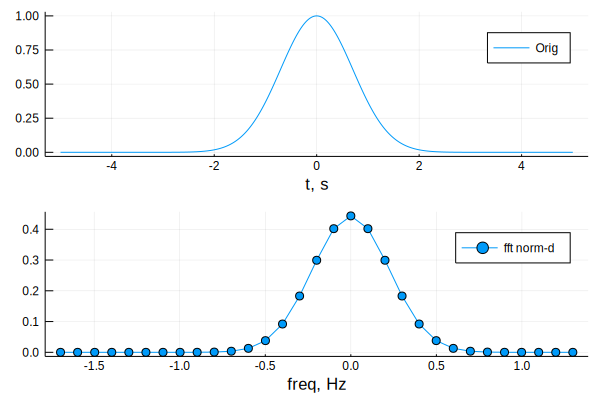

In [4]:
fftn(t, f1, 240, 270) # последние два аргумента - границы окна

Еще ряд примеров:

In [5]:
t1 = collect( range(0,10,length = 512) )
f2 = sin.(2pi*t1) + 0.5sin.(pi*t1);

nu: 0.998 Hz


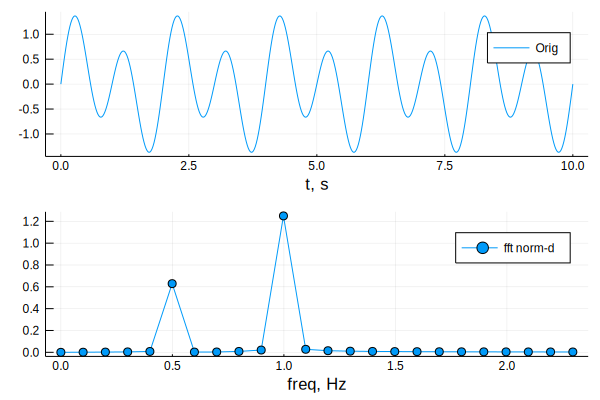

In [6]:
fftn(t1, f2, 257, 280)

In [7]:
y1(x) = U1*sin(w1*x)
y2(x) = U1*sin(w1*x) + U2*sin(w2*x)
y3(x) = U1*sin(w1*x).*( 1.0 + tanh(μ*x) ) + U2*sin(w2*x).*(1.0-tanh(μ*x) )
y4(x) = sin(250pi*x^2)

X = range(0,  1,  length = 2048) |> collect
x1 = range(0,  180,  length = 512) |> collect;

U1 = 1.0
U2 = 1.0
T1 = 50
T2 = 10
μ = 0.01

w1 = 2pi/T1
w2 = 2pi/T2

Y1 = y1.(x1)
Y2 = y2.(x1)
Y3 = y3.(x1)
Y4 = y4.(X)

w1, w2

(0.12566370614359174, 0.6283185307179586)

nu: 0.022 Hz


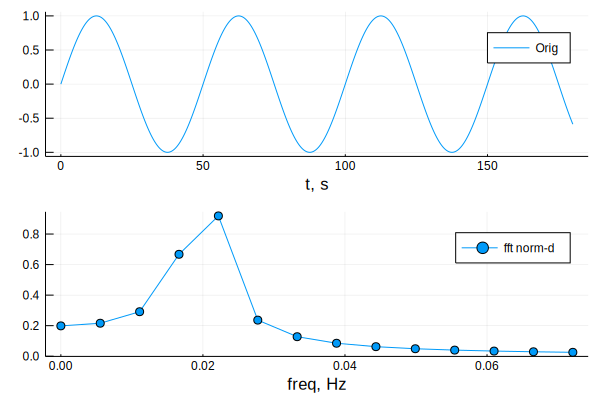

In [8]:
fftn(x1, Y1, 257, 270)

Для того, чтоб сгладить боковые лепестки (уточнить значение частоты), нужно стараться брать целое количество периодов, т е `x1 = range(0,  150,  length = 512) |> collect;` так как период равен 50.

nu: 0.1 Hz


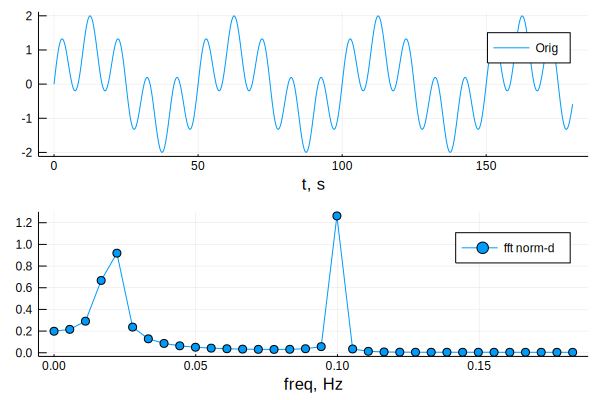

In [9]:
fftn(x1, Y2, 257, 290)

nu: 0.022 Hz


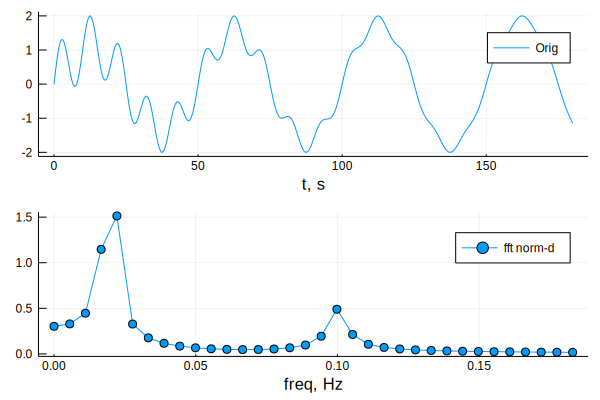

In [10]:
fftn(x1, Y3, 257, 290)

Сиглал с переменной частотой:

nu: 236.884 Hz


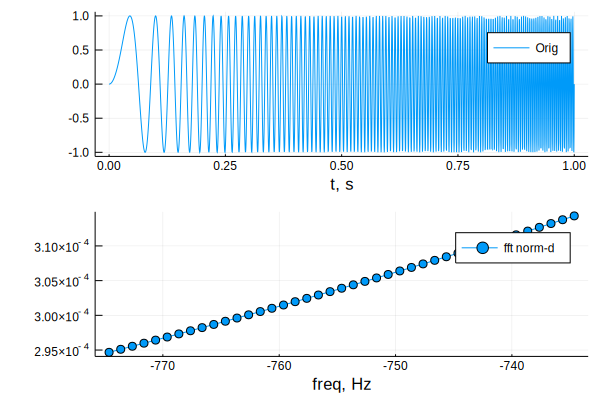

In [11]:
fftn(X, Y4, 250, 290)

In [12]:
N=10000
dt = 1e-4
xa = range(0, 1, length=N) |> collect
xb = range(0, 1/4, length=N ÷ 4) |> collect

freqs = [4, 30, 60, 90]

f5(t) = sin.(2pi*freqs*t)

y00 = hcat( [f5(x) for x in xa]... )
y11 = vec( sum(y00, dims = 1) ) 

y00 = hcat( [f5(x) for x in xb]... )
y01 = permutedims(y00)
y22 = reshape(y01, N, 1) |> vec;

nu: 29.997 Hz


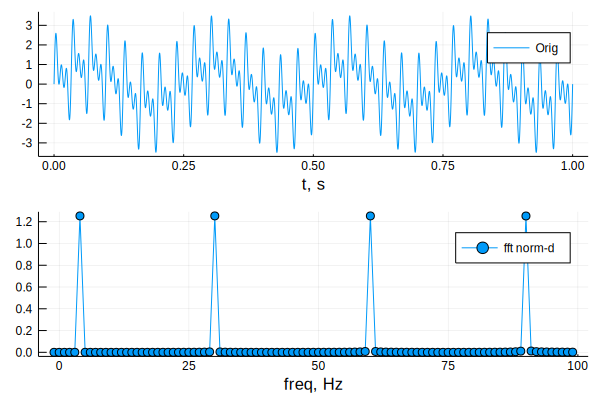

In [13]:
fftn(xa, y11, 5000, 5100)

Здесь четыре различные частоты присутствующие в сигнале на протяжении всего измерения - поэтому всё хорошо очертилось.

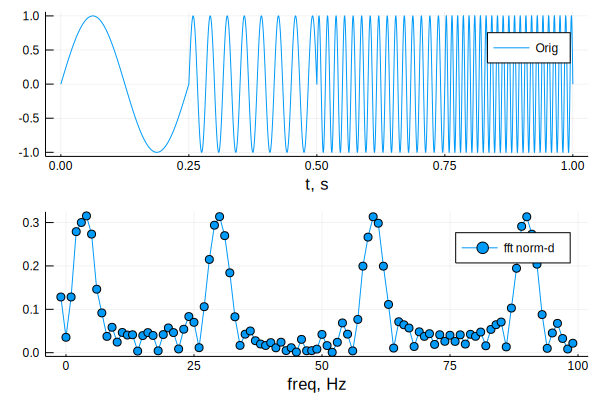

nu: 4.0 Hz


In [14]:
fftn(xa, y22, 5000, 5100)

На этом графике сигналы не перекрываются во времени, боковые лепестки обусловлены разрывом между четырьмя различными частотами.
https://habr.com/ru/post/451278/
